In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False  

In [3]:
# 读取数据文件
df = pd.read_csv('../data/ads_20250511_021655_077.csv')


# 重命名列名
df.columns = ['timestamp','voltage', 'duration']

# 将时间戳转换为datetime类型
df['timestamp'] = pd.to_datetime(df['timestamp'])

# 显示数据基本信息
print("数据基本信息：")
print(df.info())

# 显示前几行数据
print("\n数据预览：")
display(df.head())


数据基本信息：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 383165 entries, 0 to 383164
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype              
---  ------     --------------   -----              
 0   timestamp  383165 non-null  datetime64[ns, UTC]
 1   voltage    383165 non-null  float64            
 2   duration   383165 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(1), int64(1)
memory usage: 8.8 MB
None

数据预览：


,timestamp,voltage,duration
0,2025-05-11 02:16:57.056000+00:00,43.395996,1741
1,2025-05-11 02:16:57.191000+00:00,43.350220,1876
2,2025-05-11 02:16:57.326000+00:00,43.395996,2011
3,2025-05-11 02:16:58.460000+00:00,43.441772,2145
4,2025-05-11 02:16:58.594000+00:00,43.441772,2279


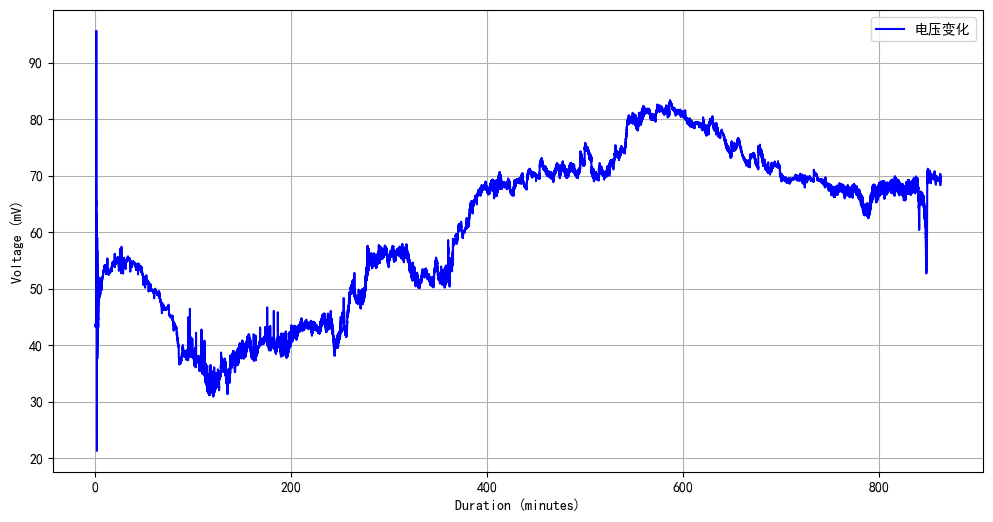

In [4]:
plt.figure(figsize=(12, 6))
plt.plot(df['duration'] / 60000, df['voltage'], label='电压变化', color='b')  # 将ms转换为分钟
plt.xlabel('Duration (minutes)')
plt.ylabel('Voltage (mV)')
plt.legend()
plt.grid(True)
plt.show()

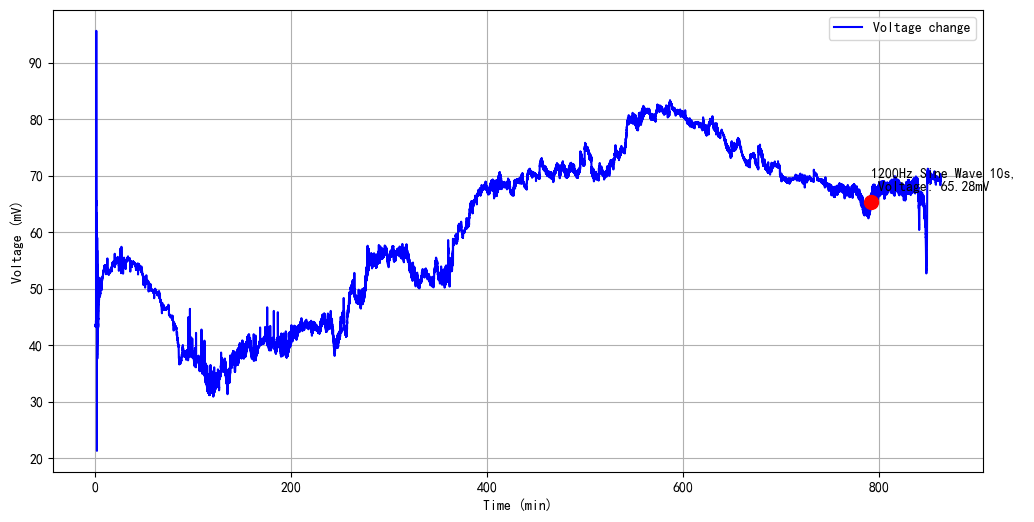

In [5]:
# 将特定时间点转换为datetime格式
specific_time = pd.to_datetime('2025-05-11T15:28:07.355Z')

# 检查这个时间点是否在数据范围内
if specific_time >= df['timestamp'].min() and specific_time <= df['timestamp'].max():
    # 找到最接近的时间点
    closest_idx = (df['timestamp'] - specific_time).abs().idxmin()
    closest_point = df.iloc[closest_idx]
    
    # 绘制电压随时间变化的折线图，并标注特定时间点
    plt.figure(figsize=(12, 6))
    plt.plot(df['duration'] / 60000, df['voltage'], label='Voltage change', color='b')
    
    # 标注特定时间点
    plt.scatter(closest_point['duration'] / 60000, closest_point['voltage'], 
                color='red', s=100, zorder=5)
    plt.annotate(f'1200Hz Sine Wave 10s, \n Voltage: {closest_point["voltage"]:.2f}mV', 
                xy=(closest_point['duration'] / 60000, closest_point['voltage']),
                xytext=(closest_point['duration'] / 60000 + 0.5, closest_point['voltage'] + 2),
                fontsize=10)
    
    plt.xlabel('Time (min)')
    plt.ylabel('Voltage (mV)')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("指定的时间点不在数据范围内！")
    print(f"数据时间范围: {df['timestamp'].min()} 到 {df['timestamp'].max()}")


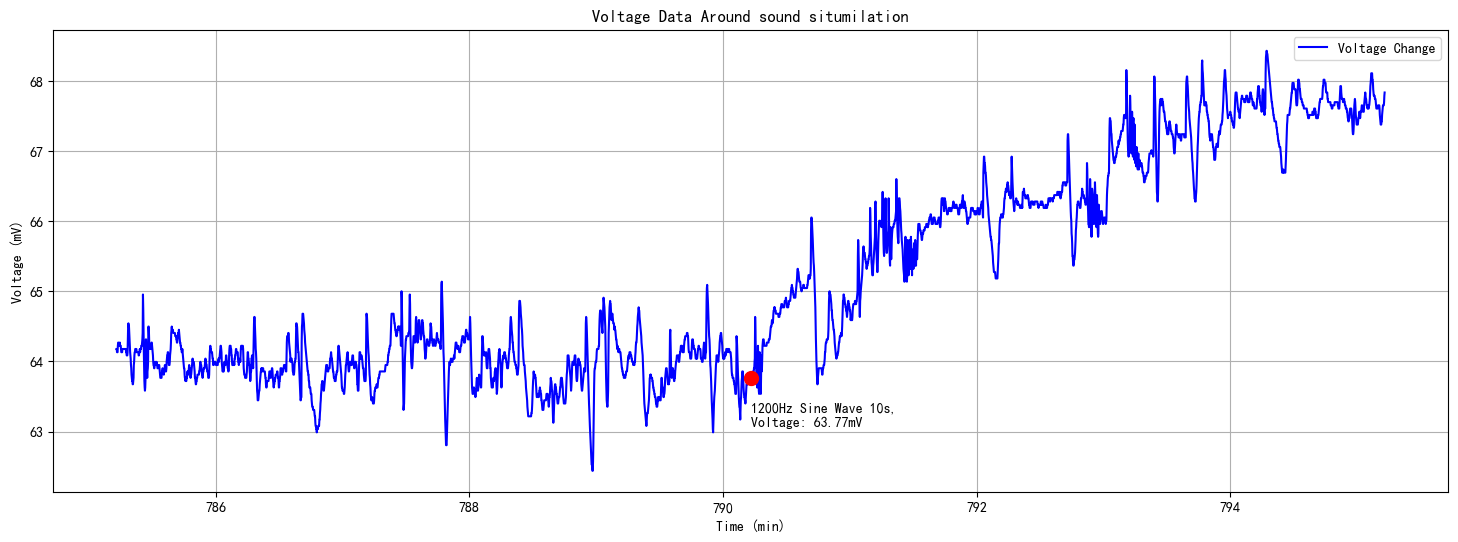

In [18]:
# Convert specific time point to datetime format
specific_time = pd.to_datetime('2025-05-11T15:27:07.355Z')

# Check if this time point is within the data range
if specific_time >= df['timestamp'].min() and specific_time <= df['timestamp'].max():
    # Find the closest time point
    closest_idx = (df['timestamp'] - specific_time).abs().idxmin()
    closest_point = df.iloc[closest_idx]
    
    # Calculate the time window (5 minutes before and after the specific time)
    closest_duration_min = closest_point['duration'] / 60000  # Convert to minutes
    time_window_min = 5  # 5 minutes window
    
    # Filter data within the time window
    # min_duration = (closest_duration_min - (time_window_min - 1.7)) * 60000
    # max_duration = (closest_duration_min + (time_window_min + 1.4)) * 60000
    min_duration = (closest_duration_min - (time_window_min)) * 60000
    max_duration = (closest_duration_min + (time_window_min)) * 60000
    filtered_df = df[(df['duration'] >= min_duration) & (df['duration'] <= max_duration)]
    
    # Plot voltage changes over time, and mark the specific time point
    plt.figure(figsize=(18, 6))
    plt.plot(filtered_df['duration'] / 60000, filtered_df['voltage'], label='Voltage Change', color='b')
    
    # Mark the specific time point
    plt.scatter(closest_point['duration'] / 60000, closest_point['voltage'], 
                color='red', s=100, zorder=5)
    plt.annotate(f'1200Hz Sine Wave 10s, \nVoltage: {closest_point["voltage"]:.2f}mV', 
                xy=(closest_point['duration'] / 60000, closest_point['voltage']),
                xytext=(closest_point['duration'] / 60000, closest_point['voltage'] - 0.7),
                fontsize=10)
    
    # Set axis labels and title
    plt.xlabel('Time (min)')
    plt.ylabel('Voltage (mV)')
    plt.title(f'Voltage Data Around sound situmilation')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("The specified time point is not within the data range!")
    print(f"Data time range: {df['timestamp'].min()} to {df['timestamp'].max()}")


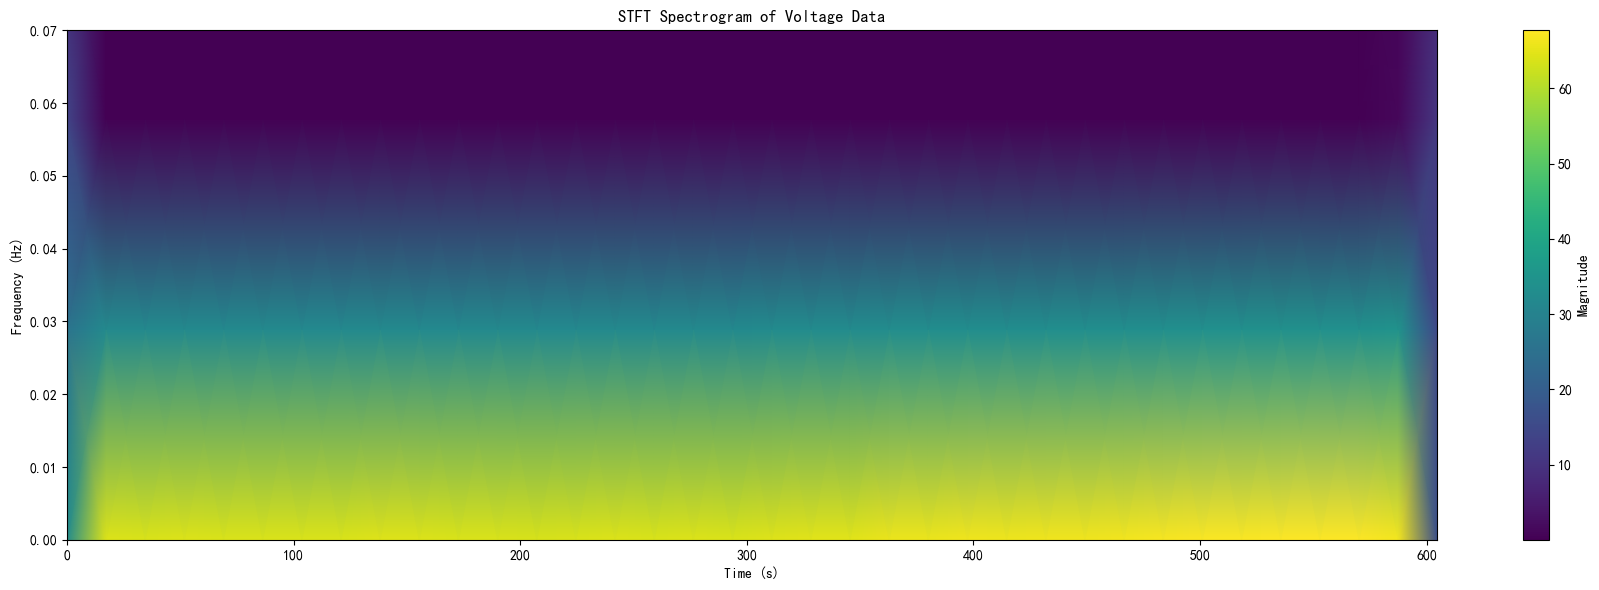

In [24]:
# Perform STFT (Short-Time Fourier Transform) on the filtered data
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

# Get the voltage data and sampling rate
voltage_data = filtered_df['voltage'].values
sampling_rate = 1 / (filtered_df['duration'].diff().mean() / 1000)  # Convert to Hz

# Perform STFT
f, t, Zxx = signal.stft(voltage_data, fs=sampling_rate, nperseg=256, noverlap=128)

# Create a DataFrame to store all STFT data
# The shape of Zxx is (frequency bins, time points)
# We need to reshape the data correctly to avoid dimension mismatch

# Plot the STFT results as a spectrogram
plt.figure(figsize=(18, 6))
plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud')
plt.colorbar(label='Magnitude')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.title('STFT Spectrogram of Voltage Data')
plt.ylim([0, 0.07])  # Limit y-axis to 0-0.2 Hz
plt.tight_layout()
plt.show()


Analyzing frequency: 0.0289 Hz (closest to 0.02 Hz)
Average magnitude before stimulation: 31.6395
Average magnitude after stimulation: 32.2136
Change: 0.5740 (1.81%)


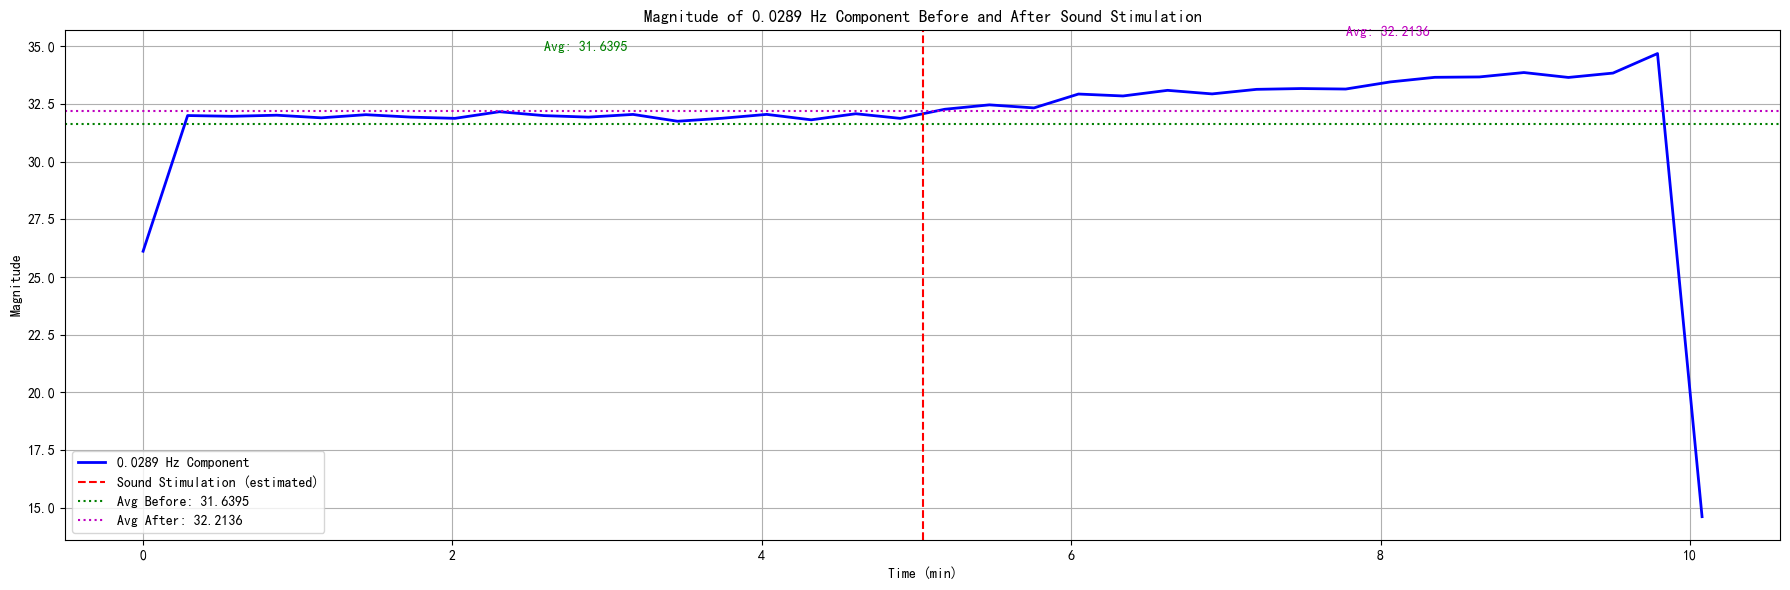

In [25]:
# Analyze the 0.02Hz frequency band before and after sound stimulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Find the closest frequency to 0.02Hz in the STFT results
target_freq = 0.02
freq_idx = np.argmin(np.abs(f - target_freq))
actual_freq = f[freq_idx]
print(f"Analyzing frequency: {actual_freq:.4f} Hz (closest to 0.02 Hz)")

# Extract the magnitude data for this frequency
freq_magnitude = np.abs(Zxx[freq_idx, :])

# Create a time axis in minutes for better visualization
time_min = t / 60

# Plot the magnitude of the 0.02Hz component over time
plt.figure(figsize=(18, 6))

# Plot the magnitude
plt.plot(time_min, freq_magnitude, 'b-', linewidth=2, label=f'{actual_freq:.4f} Hz Component')

# Find the time of sound stimulation (assuming it's at the center of the filtered data)
sound_time = t.mean()
sound_time_min = sound_time / 60
plt.axvline(x=sound_time_min, color='r', linestyle='--', label='Sound Stimulation (estimated)')

# Calculate average magnitude before and after stimulation
before_mask = t < sound_time
after_mask = t >= sound_time

avg_before = np.mean(freq_magnitude[before_mask])
avg_after = np.mean(freq_magnitude[after_mask])

print(f"Average magnitude before stimulation: {avg_before:.4f}")
print(f"Average magnitude after stimulation: {avg_after:.4f}")
print(f"Change: {(avg_after - avg_before):.4f} ({(avg_after - avg_before)/avg_before*100:.2f}%)")

# Add horizontal lines showing the average values
plt.axhline(y=avg_before, color='g', linestyle=':', label=f'Avg Before: {avg_before:.4f}')
plt.axhline(y=avg_after, color='m', linestyle=':', label=f'Avg After: {avg_after:.4f}')

# Add annotations
plt.annotate(f"Avg: {avg_before:.4f}", xy=(time_min[len(time_min)//4], avg_before), 
             xytext=(time_min[len(time_min)//4], avg_before*1.1), color='g')
plt.annotate(f"Avg: {avg_after:.4f}", xy=(time_min[3*len(time_min)//4], avg_after), 
             xytext=(time_min[3*len(time_min)//4], avg_after*1.1), color='m')

# Set axis labels and title
plt.xlabel('Time (min)')
plt.ylabel('Magnitude')
plt.title(f'Magnitude of {actual_freq:.4f} Hz Component Before and After Sound Stimulation')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Calculate energy (integral of magnitude squared) before and after stimulation
energy_before = np.sum(freq_magnitude[before_mask]**2)
energy_after = np.sum(freq_magnitude[after_mask]**2)

# Normalize by the number of samples to get average energy
num_samples_before = np.sum(before_mask)
num_samples_after = np.sum(after_mask)
avg_energy_before = energy_before / num_samples_before
avg_energy_after = energy_after / num_samples_after

print("\nEnergy Analysis:")
print(f"Total energy before stimulation: {energy_before:.4f}")
print(f"Total energy after stimulation: {energy_after:.4f}")
print(f"Average energy before stimulation: {avg_energy_before:.4f}")
print(f"Average energy after stimulation: {avg_energy_after:.4f}")
print(f"Energy change: {(avg_energy_after - avg_energy_before):.4f} ({(avg_energy_after - avg_energy_before)/avg_energy_before*100:.2f}%)")



Energy Analysis:
Total energy before stimulation: 18051.5116
Total energy after stimulation: 19013.0944
Average energy before stimulation: 1002.8618
Average energy after stimulation: 1056.2830
Energy change: 53.4213 (5.33%)


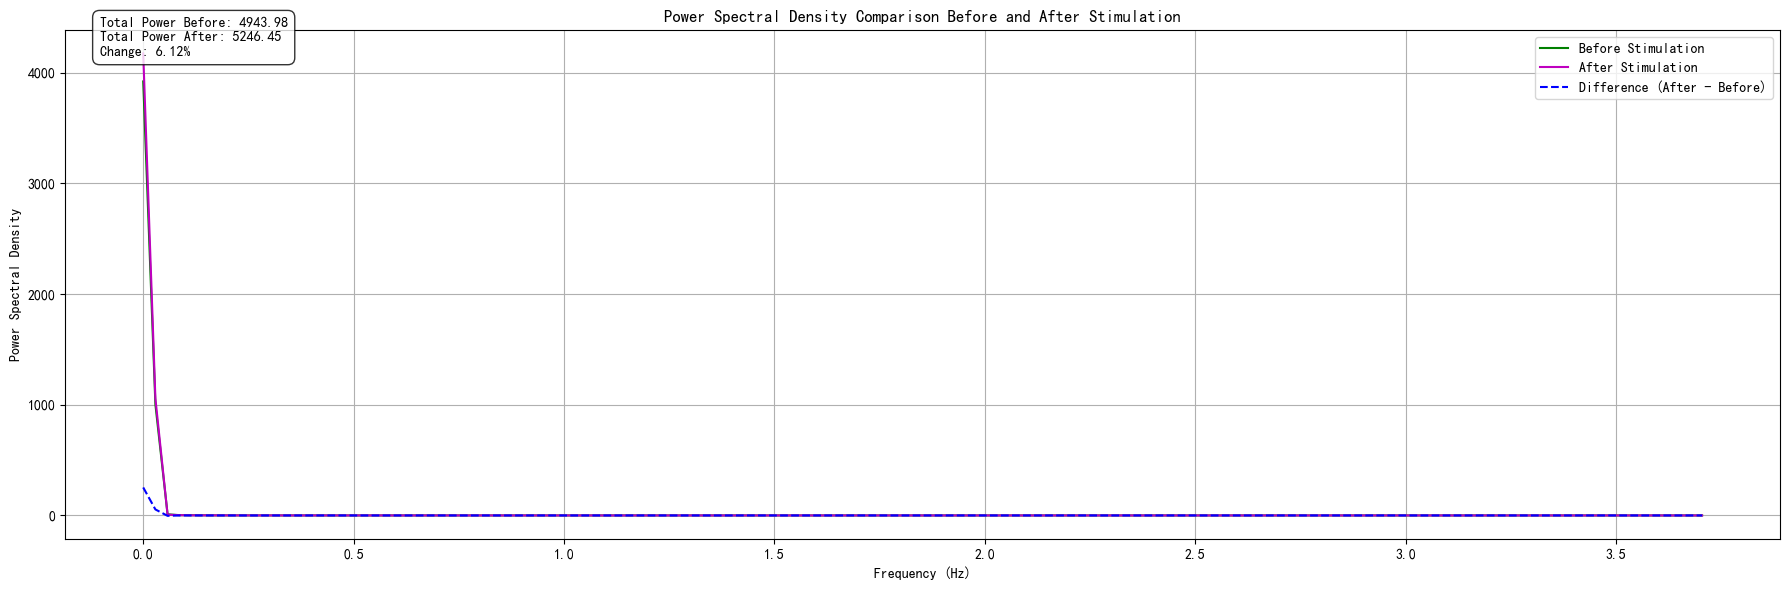


Power Spectral Density Analysis:
Total power before stimulation: 4943.9769
Total power after stimulation: 5246.4520
Absolute power change: 302.4751
Relative power change: 6.12%

Top 5 frequencies with largest power increase:
    Frequency       Before        After  Absolute_Change  Percent_Change
0    0.000000  3921.311734  4174.265330       252.953596        6.450739
1    0.028939  1002.861753  1057.137070        54.275318        5.412044
3    0.086817     2.600391     2.646017         0.045627        1.754606
5    0.144695     0.926859     0.819737        -0.107122      -11.557554
16   0.463025     0.091042     0.078356        -0.012686      -13.934514

Top 5 frequencies with largest power decrease:
    Frequency     Before     After  Absolute_Change  Percent_Change
2    0.057878  10.317810  6.824787        -3.493023      -33.854304
4    0.115756   1.661592  1.186143        -0.475449      -28.614040
12   0.347269   0.169471  0.137660        -0.031811      -18.770625
25   0.723477   

In [34]:
# Power Spectral Density (PSD) Analysis
import matplotlib.pyplot as plt
import numpy as np

# Use the STFT data we already calculated earlier
# f, t, Zxx were calculated using signal.stft(voltage_data, fs=sampling_rate, nperseg=256, noverlap=128)

# Calculate power (magnitude squared)
power_matrix = np.abs(Zxx) ** 2

# Convert time to minutes for consistency with previous plots
time_min = t / 60

# Define the stimulation time point (assuming same as before)
stim_time = time_min[len(time_min) // 2]  # Middle point as stimulation time

# Create masks for before and after stimulation
before_mask_time = time_min < stim_time
after_mask_time = time_min > stim_time

# Calculate average PSD before and after stimulation
avg_psd_before = np.mean(power_matrix[:, before_mask_time], axis=1)
avg_psd_after = np.mean(power_matrix[:, after_mask_time], axis=1)

# Plot the power spectral density comparison
plt.figure(figsize=(18, 6))
plt.plot(f, avg_psd_before, 'g-', label='Before Stimulation')
plt.plot(f, avg_psd_after, 'm-', label='After Stimulation')

# Calculate and display the difference
psd_diff = avg_psd_after - avg_psd_before
plt.plot(f, psd_diff, 'b--', label='Difference (After - Before)')

# Set axis labels and title
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.title('Power Spectral Density Comparison Before and After Stimulation')
plt.grid(True)
plt.legend()

# Add text box with summary statistics
total_power_before = np.sum(avg_psd_before)
total_power_after = np.sum(avg_psd_after)
power_change = (total_power_after - total_power_before) / total_power_before * 100

stats_text = f"Total Power Before: {total_power_before:.2f}\n"
stats_text += f"Total Power After: {total_power_after:.2f}\n"
stats_text += f"Change: {power_change:.2f}%"

plt.annotate(stats_text, xy=(0.02, 0.95), xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.8))

plt.tight_layout()
plt.show()

# Print detailed statistics
print("\nPower Spectral Density Analysis:")
print(f"Total power before stimulation: {total_power_before:.4f}")
print(f"Total power after stimulation: {total_power_after:.4f}")
print(f"Absolute power change: {total_power_after - total_power_before:.4f}")
print(f"Relative power change: {power_change:.2f}%")

# Find frequency bands with the most significant changes
freq_change_percent = (avg_psd_after - avg_psd_before) / (avg_psd_before + 1e-10) * 100  # Avoid division by zero
significant_changes = pd.DataFrame({
    'Frequency': f,
    'Before': avg_psd_before,
    'After': avg_psd_after,
    'Absolute_Change': avg_psd_after - avg_psd_before,
    'Percent_Change': freq_change_percent
})

# Display top 5 frequencies with largest increase and decrease
print("\nTop 5 frequencies with largest power increase:")
print(significant_changes.sort_values('Percent_Change', ascending=False).head(5))

print("\nTop 5 frequencies with largest power decrease:")
print(significant_changes.sort_values('Percent_Change', ascending=True).head(5))
